# The COVID-19 Case rising due to overseas travel
This notebook will analysis the Covid case due to the overseas travel. This analysis show international travel inside the country is the reason for spreading the increasing case. After finishing this analysis, the final result will connect with the analysis of study case of lockdown country.

In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist
from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import confusion_matrix, accuracy_score
from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

## The dataset
There are two datasets using to this analysis which collect the introduce about oversea travel in each country in every different time, other dataset is the information of covid-19 cases each day from the started outbreak until now. Two datasets are taken from [Oxford University](https://ourworldindata.org/grapher/international-travel-covid) about time series covid-cases and covid-19 government measure dataset from [Acaps](https://www.acaps.org/covid-19-government-measures-dataset).

In [2]:
# Read the datasets
df1 = pd.read_excel(open('data/covid-19 measure.xlsx', 'rb'),sheet_name='Dataset')
df2 = pd.read_csv("files/owid-covid-data.csv")

In [3]:
df1.head()

,ID,ISO,COUNTRY,REGION,ADMIN_LEVEL_NAME,PCODE,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
0,4245,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Awareness campaigns,NaN,MoPH begins announcements on their facebook to...,NaN,2020-01-24,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/posts/1005130...,2020-04-07,NaN
1,4246,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,checked,Health teams at airports will check passengers...,NaN,2020-01-26,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/posts/1006458...,2020-04-07,NaN
2,4247,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Movement restrictions,International flights suspension,checked,Flights to China are suspended.,NaN,2020-01-27,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/photos/a.4625...,2020-04-07,NaN
3,4248,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,NaN,Health screenings of all passengers at airports.,NaN,2020-01-27,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/photos/a.4625...,2020-04-07,NaN
4,23,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Movement restrictions,Border checks,checked,All China and Iran nationals,NaN,2020-02-01,US Embassy,Government,https://af.usembassy.gov/covid-19-information/,2020-03-14,NaN


In [4]:
# change data type of column 'DATE_IMPLEMENTED' to datetime
df1['DATE_IMPLEMENTED'] = pd.to_datetime(df1['DATE_IMPLEMENTED'])

In [5]:
# change data type of column 'date' to datatime
df2['date'] = pd.to_datetime(df2['date'])
df2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125960,ZWE,Africa,Zimbabwe,2021-10-20,132437.0,32.0,47.000,4659.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125961,ZWE,Africa,Zimbabwe,2021-10-21,132540.0,103.0,41.286,4662.0,3.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125962,ZWE,Africa,Zimbabwe,2021-10-22,132588.0,48.0,43.286,4663.0,1.0,1.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125963,ZWE,Africa,Zimbabwe,2021-10-23,132588.0,0.0,36.429,4663.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


## The data cleaning and choosen
This analysis choose top 10 ranking countries which has the most Covid-19 case following [Coronavirus Worldwide](https://news.google.com/covid19/map?hl=en-US&mid=%2Fm%2F02j71&gl=US&ceid=US%3Aen&fbclid=IwAR3cbK68cJD4DY_4ducZ58hl5i6Y3ITb7wIkv1WwrHzTLYMtkQfqt3DwAeQ):
1. United States
2. India
3. Brazil
4. Russia
5. Turkey
6. France
7. Iran
8. Argentina
9. Spain
10. Germany

In [6]:
# drop columns unnessesary to analysis
measure=df1.drop(columns=['ID', 'ISO','ADMIN_LEVEL_NAME','PCODE','LOG_TYPE','TARGETED_POP_GROUP','NON_COMPLIANCE','LINK','SOURCE_TYPE','ENTRY_DATE','Alternative source'])
measure.head()

,COUNTRY,REGION,CATEGORY,MEASURE,COMMENTS,DATE_IMPLEMENTED,SOURCE
0,Afghanistan,Asia,Public health measures,Awareness campaigns,MoPH begins announcements on their facebook to...,2020-01-24,Afghanistan MoPH
1,Afghanistan,Asia,Public health measures,Health screenings in airports and border cross...,Health teams at airports will check passengers...,2020-01-26,Afghanistan MoPH
2,Afghanistan,Asia,Movement restrictions,International flights suspension,Flights to China are suspended.,2020-01-27,Afghanistan MoPH
3,Afghanistan,Asia,Public health measures,Health screenings in airports and border cross...,Health screenings of all passengers at airports.,2020-01-27,Afghanistan MoPH
4,Afghanistan,Asia,Movement restrictions,Border checks,All China and Iran nationals,2020-02-01,US Embassy


In [7]:
# choose ten countries and mesure of control covid 
country1 = measure["COUNTRY"].isin(
["Argentina", "Germany", "France","India", "Iran", "Spain", "United States","Turkey","Brazil","Russia","Colombia","Italy","Indonesia","Mexico","Ukraine"])
measr = measure["MEASURE"].isin(["International flights suspension", "Border closure"])
cmeasure = measure[measr & country1]
cmeasure

,COUNTRY,REGION,CATEGORY,MEASURE,COMMENTS,DATE_IMPLEMENTED,SOURCE
662,Argentina,Americas,Movement restrictions,International flights suspension,Flights from countries with COVID transmissions.,2020-03-12,Ministry of Foreign Affairs - France
681,Argentina,Americas,Movement restrictions,Border closure,Countryï¿½s borders are closed for all those e...,2020-03-26,Foreign Ministry ï¿½ UK
682,Argentina,Americas,Movement restrictions,Border closure,Border closure is extended until 31st of March.,2020-03-26,MoH
692,Argentina,Americas,Movement restrictions,Border closure,The government reopened its borders (closed si...,2020-04-01,Government ï¿½ Argentina
697,Argentina,Americas,Movement restrictions,Border closure,Extension: Borders are closed to foreign natio...,2020-04-13,Foreign Ministry ï¿½ UK
...,...,...,...,...,...,...,...
23234,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59670 exte...",2020-09-23,Federal Register
23235,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59669 exte...",2020-09-23,Federal Register
23238,United States,Americas,Movement restrictions,Border closure,"CDC extended its No Sail Order a third time, e...",2020-09-30,CDC
23280,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 7, at 85 FR 67276 (Oct...",2020-10-22,NAFSA


In [194]:
# drop columns unnessesary from covid data and change the name of columns
df2.drop(df2.columns.difference(['date','location', 'total_cases', 'new_cases', 'continnent']), 1, inplace=True)
dict = {'location': 'COUNTRY',
        'date': 'DATE_IMPLEMENTED'}
df2.rename(columns=dict,inplace=True)
df2

,COUNTRY,DATE_IMPLEMENTED,total_cases,new_cases
0,Afghanistan,2020-02-24,5.0,5.0
1,Afghanistan,2020-02-25,5.0,0.0
2,Afghanistan,2020-02-26,5.0,0.0
3,Afghanistan,2020-02-27,5.0,0.0
4,Afghanistan,2020-02-28,5.0,0.0
...,...,...,...,...
125960,Zimbabwe,2021-10-20,132437.0,32.0
125961,Zimbabwe,2021-10-21,132540.0,103.0
125962,Zimbabwe,2021-10-22,132588.0,48.0
125963,Zimbabwe,2021-10-23,132588.0,0.0


In [195]:
# join two tables to create new table with total case and the measure
case = pd.merge(cmeasure, df2, on=['COUNTRY', 'DATE_IMPLEMENTED'], how = 'left')
case

,COUNTRY,REGION,CATEGORY,MEASURE,COMMENTS,DATE_IMPLEMENTED,SOURCE,total_cases,new_cases
0,Argentina,Americas,Movement restrictions,International flights suspension,Flights from countries with COVID transmissions.,2020-03-12,Ministry of Foreign Affairs - France,19.0,0.0
1,Argentina,Americas,Movement restrictions,Border closure,Countryï¿½s borders are closed for all those e...,2020-03-26,Foreign Ministry ï¿½ UK,502.0,115.0
2,Argentina,Americas,Movement restrictions,Border closure,Border closure is extended until 31st of March.,2020-03-26,MoH,502.0,115.0
3,Argentina,Americas,Movement restrictions,Border closure,The government reopened its borders (closed si...,2020-04-01,Government ï¿½ Argentina,1054.0,0.0
4,Argentina,Americas,Movement restrictions,Border closure,Extension: Borders are closed to foreign natio...,2020-04-13,Foreign Ministry ï¿½ UK,2208.0,66.0
...,...,...,...,...,...,...,...,...,...
163,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59670 exte...",2020-09-23,Federal Register,6939234.0,38911.0
164,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59669 exte...",2020-09-23,Federal Register,6939234.0,38911.0
165,United States,Americas,Movement restrictions,Border closure,"CDC extended its No Sail Order a third time, e...",2020-09-30,CDC,7233294.0,39100.0
166,United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 7, at 85 FR 67276 (Oct...",2020-10-22,NAFSA,8434997.0,76205.0


## Analysis the international suspension and border closure

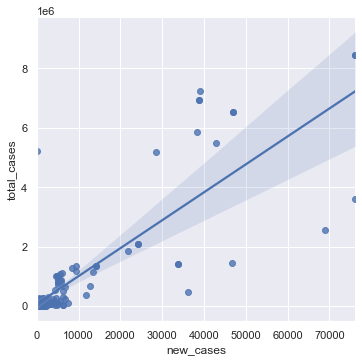

In [196]:
sns.lmplot(x = 'new_cases', y = 'total_cases', data = case)

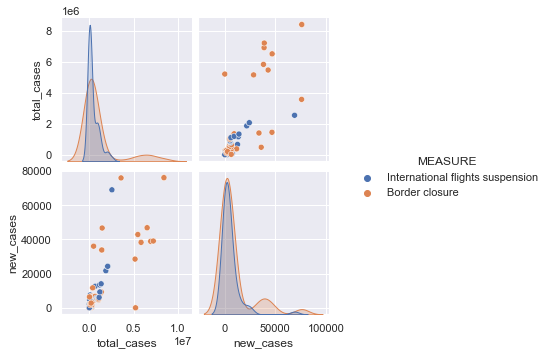

In [197]:
sns.pairplot(case, hue = 'MEASURE')

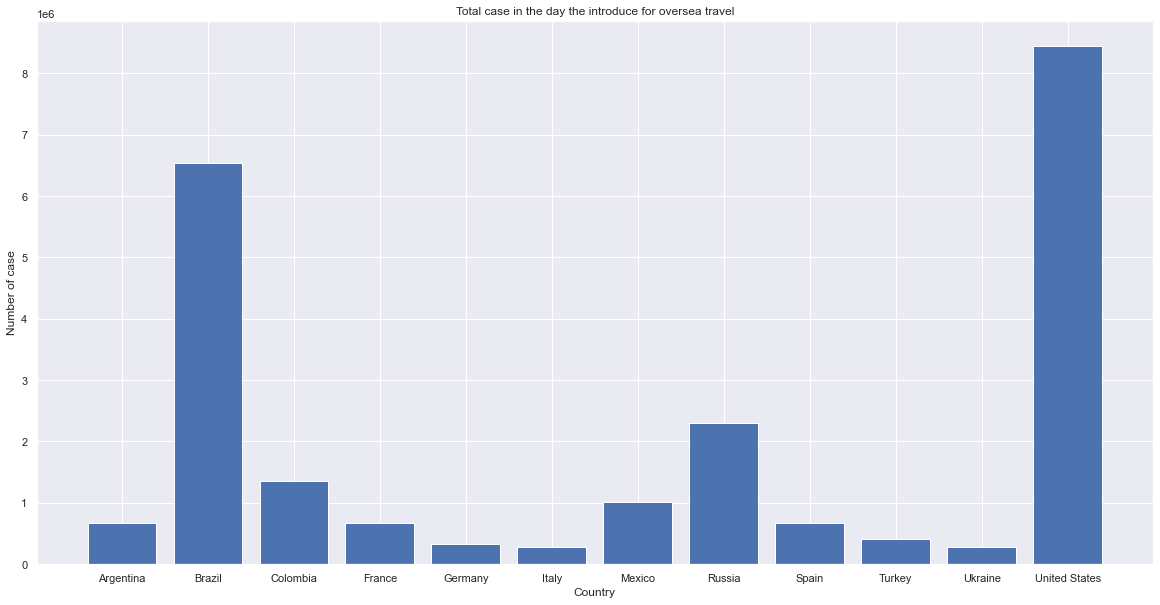

In [161]:
fig = plt.figure(figsize = (20, 10))
plt.bar(case['COUNTRY'], case['total_cases'])
plt.title('Total case in the day the introduce for oversea travel')
plt.xlabel('Country')
plt.ylabel('Number of case')
plt.show()

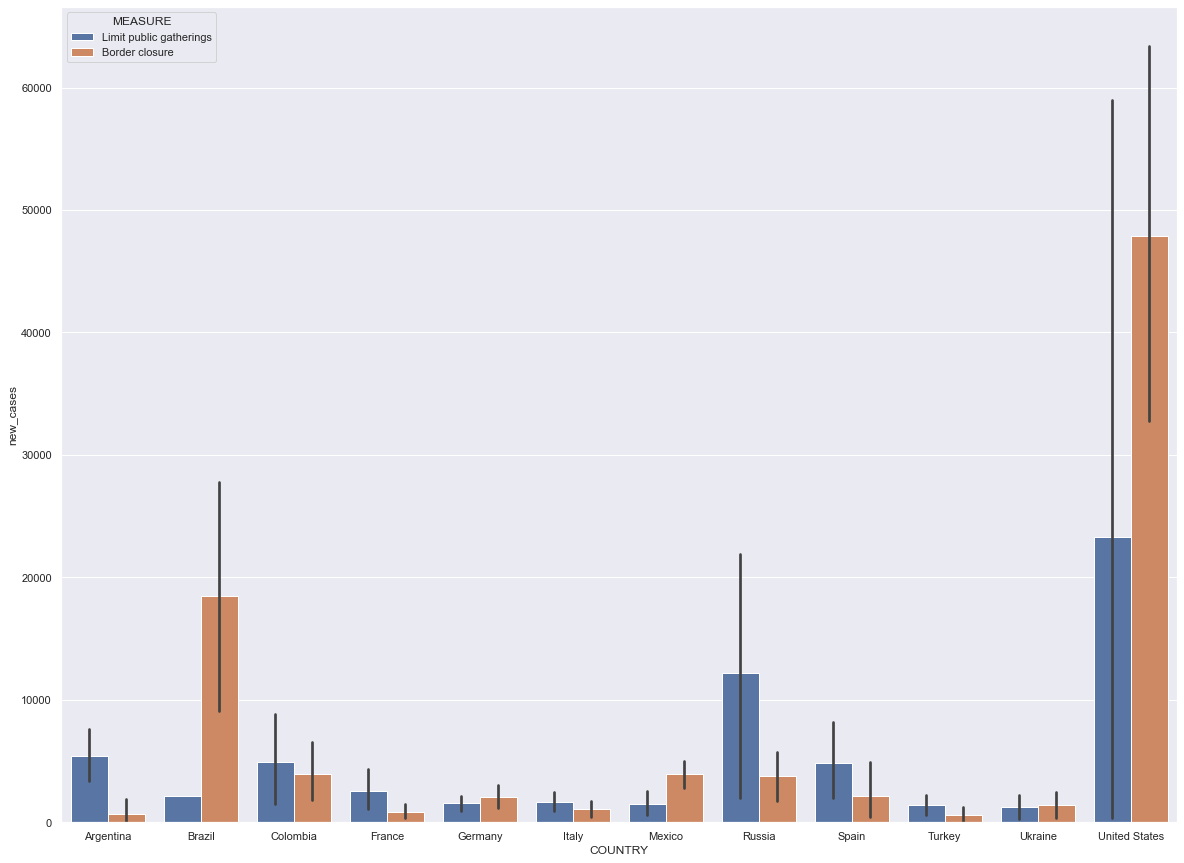

In [162]:
sns.barplot(x="COUNTRY", y='new_cases',hue="MEASURE", data=case)
sns.set(rc={'figure.figsize':(20,15)})

<AxesSubplot:xlabel='COUNTRY', ylabel='new_cases'>

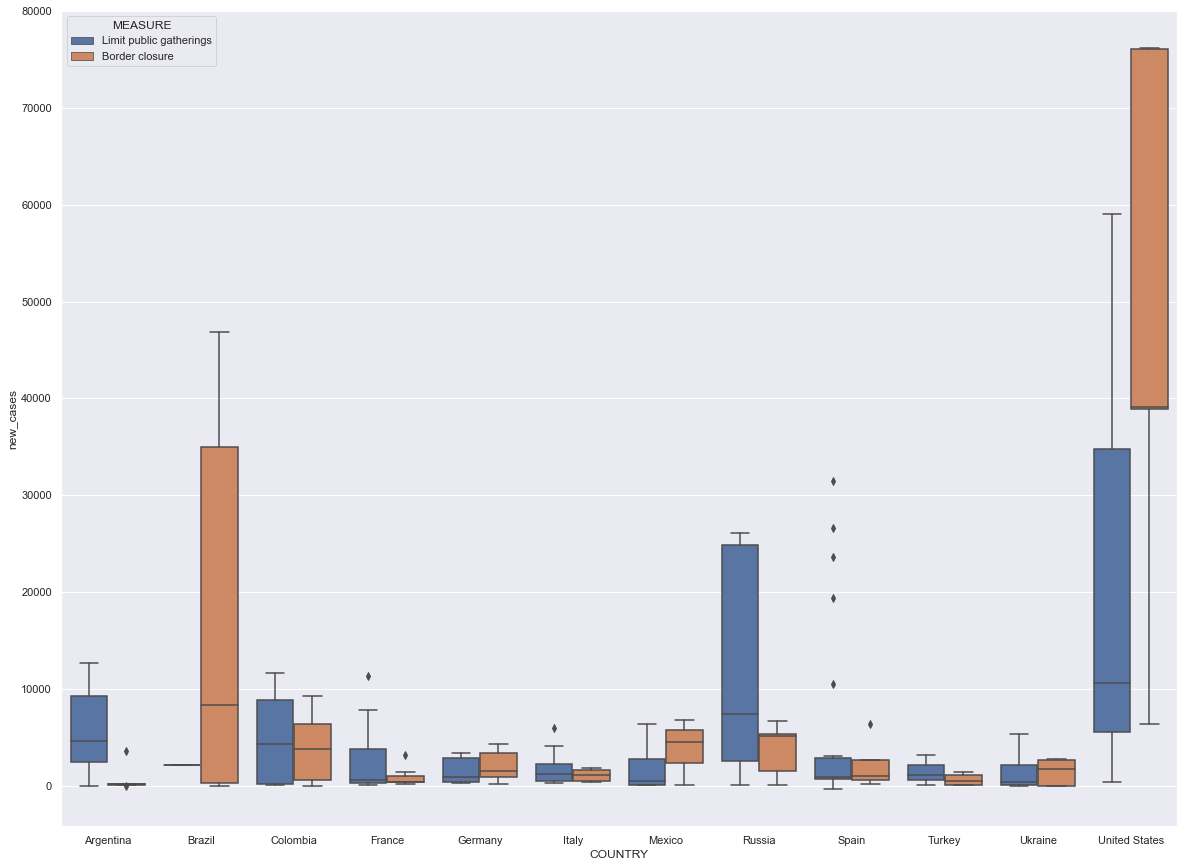

In [163]:
sns.boxplot(x="COUNTRY", y="new_cases", hue="MEASURE",data=case)

## Hierarchical Clustering

In [248]:
# set column 'Name' as the index of the Dataframe
Hcase = case.set_index('COUNTRY')
Hcase

,REGION,CATEGORY,MEASURE,COMMENTS,DATE_IMPLEMENTED,SOURCE,total_cases,new_cases
COUNTRY,,,,,,,,
Argentina,Americas,Movement restrictions,International flights suspension,Flights from countries with COVID transmissions.,2020-03-12,Ministry of Foreign Affairs - France,19.0,0.0
Argentina,Americas,Movement restrictions,Border closure,Countryï¿½s borders are closed for all those e...,2020-03-26,Foreign Ministry ï¿½ UK,502.0,115.0
Argentina,Americas,Movement restrictions,Border closure,Border closure is extended until 31st of March.,2020-03-26,MoH,502.0,115.0
Argentina,Americas,Movement restrictions,Border closure,The government reopened its borders (closed si...,2020-04-01,Government ï¿½ Argentina,1054.0,0.0
Argentina,Americas,Movement restrictions,Border closure,Extension: Borders are closed to foreign natio...,2020-04-13,Foreign Ministry ï¿½ UK,2208.0,66.0
...,...,...,...,...,...,...,...,...
United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59670 exte...",2020-09-23,Federal Register,6939234.0,38911.0
United States,Americas,Movement restrictions,Border closure,"30-Day Extension Notice 6, at 85 FR 59669 exte...",2020-09-23,Federal Register,6939234.0,38911.0
United States,Americas,Movement restrictions,Border closure,"CDC extended its No Sail Order a third time, e...",2020-09-30,CDC,7233294.0,39100.0


In [256]:
# drop columns unnessesary from covid data and change the name of columns
Hcase.drop(Hcase.columns.difference(['MEASURE', 'total_cases', 'new_cases']), 1, inplace=True)
Ncase = Hcase.replace({'International flights suspension': 0, 'Border closure': 1})
Ncase

,MEASURE,total_cases,new_cases
COUNTRY,,,
Argentina,0,19.0,0.0
Argentina,1,502.0,115.0
Argentina,1,502.0,115.0
Argentina,1,1054.0,0.0
Argentina,1,2208.0,66.0
...,...,...,...
United States,1,6939234.0,38911.0
United States,1,6939234.0,38911.0
United States,1,7233294.0,39100.0


In [261]:
Ncase = Ncase.dropna()

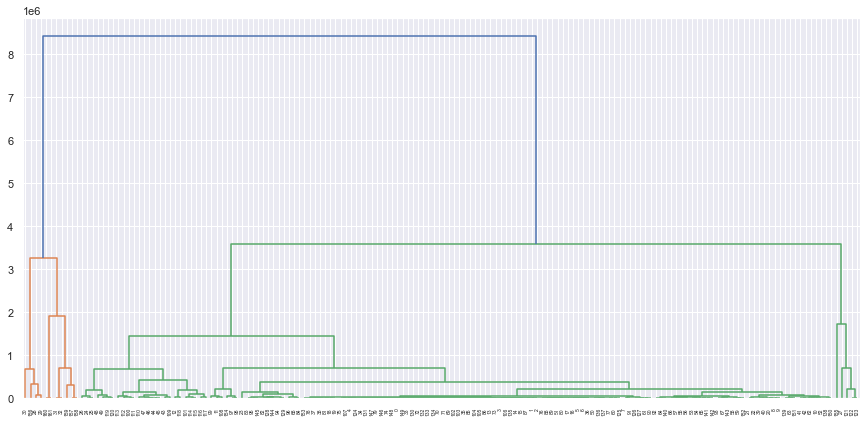

In [267]:
dist = pdist(Ncase, 'euclidean')
linkage_matrix = linkage(dist, method = 'complete')
plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.show()

### Logistic Regression and RFE

In [270]:
# Examine the data: check number of rows and number of columns
case.shape

(168, 9)

In [271]:
# The statistical summary of dataset
case.describe()

,total_cases,new_cases
count,1.620000e+02,162.000000
mean,7.642827e+05,7441.098765
std,1.698075e+06,14956.715900
min,2.000000e+00,0.000000
25%,3.913250e+03,209.250000
50%,1.336705e+05,2033.000000
75%,7.513565e+05,5411.500000
max,8.434997e+06,76205.000000


In [272]:
# Drop some columns to analysis
Ocase = case.drop(columns=['COMMENTS', 'SOURCE','REGION','CATEGORY'])
Ocase

,COUNTRY,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases
0,Argentina,International flights suspension,2020-03-12,19.0,0.0
1,Argentina,Border closure,2020-03-26,502.0,115.0
2,Argentina,Border closure,2020-03-26,502.0,115.0
3,Argentina,Border closure,2020-04-01,1054.0,0.0
4,Argentina,Border closure,2020-04-13,2208.0,66.0
...,...,...,...,...,...
163,United States,Border closure,2020-09-23,6939234.0,38911.0
164,United States,Border closure,2020-09-23,6939234.0,38911.0
165,United States,Border closure,2020-09-30,7233294.0,39100.0
166,United States,Border closure,2020-10-22,8434997.0,76205.0


In [273]:
Ocase['MEASURE'].unique()

array(['International flights suspension', 'Border closure'], dtype=object)

In [274]:
Ocase['MEASURE'].value_counts()

Border closure                      99
International flights suspension    69
Name: MEASURE, dtype: int64

In [275]:
Ocase.isna()

,COUNTRY,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
163,False,False,False,False,False
164,False,False,False,False,False
165,False,False,False,False,False
166,False,False,False,False,False


In [276]:
Ocase.isna().sum()

COUNTRY             0
MEASURE             0
DATE_IMPLEMENTED    2
total_cases         6
new_cases           6
dtype: int64

In [277]:
nan_indice = np.where(Ocase.isna().any(1).values)
nan_indice

(array([ 50,  75,  76, 133, 134, 135], dtype=int64),)

In [278]:
Ocase2 = Ocase.dropna()

In [279]:
Ocase2.shape

(162, 5)

In [280]:
Ocase3 = Ocase.fillna(0)

In [281]:
# Split your data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(Ocase2, test_size = 0.2, random_state = 142)
print(train.shape, test.shape)

(129, 5) (33, 5)


In [282]:
X_train = train.drop(['MEASURE','COUNTRY','DATE_IMPLEMENTED'], axis = 1)
y_train = train['MEASURE']
X_test = test.drop(['MEASURE','COUNTRY', 'DATE_IMPLEMENTED'], axis = 1)
y_test = test['MEASURE']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(129, 2) (129,) (33, 2) (33,)


In [283]:
# Build your Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [284]:
# Do predictions on test set
pred = model.predict(X_test)
print(pred)

['Border closure' 'Border closure' 'Border closure'
 'International flights suspension' 'Border closure' 'Border closure'
 'Border closure' 'Border closure' 'International flights suspension'
 'Border closure' 'Border closure' 'Border closure'
 'International flights suspension' 'International flights suspension'
 'International flights suspension' 'Border closure' 'Border closure'
 'Border closure' 'International flights suspension'
 'International flights suspension' 'International flights suspension'
 'Border closure' 'Border closure' 'International flights suspension'
 'International flights suspension' 'Border closure'
 'International flights suspension' 'Border closure' 'Border closure'
 'International flights suspension' 'Border closure'
 'International flights suspension' 'Border closure']


In [285]:
# Evaluate the performance of your trained model
print(accuracy_score(y_test, pred))

0.5151515151515151


In [286]:
pred_train = model.predict(X_train)
print(accuracy_score(y_train, pred_train))

0.6124031007751938


In [287]:
print(confusion_matrix(y_train, pred_train))

[[59 22]
 [28 20]]


In [288]:
pred_test = model.predict(X_test)
print(accuracy_score(y_test, pred_test))

0.5151515151515151


In [289]:
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select = 5, step =1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [290]:
accuracy_scores = []
for i in range(3,6):
    lr_model = LogisticRegression()
    rfe = RFE(estimator=lr_model, n_features_to_select = i, step =1)
    rfe.fit(X_train, y_train)
    
    pred = rfe.predict(X_test)
    accuracy_scores.append(accuracy_score(pred, y_test))
    
print(accuracy_scores)

[0.5151515151515151, 0.5151515151515151, 0.5151515151515151]


In [291]:
print(rfe.ranking_)

[1 1]


In [292]:
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)

MultinomialNB()

In [293]:
y_pred = clf_mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is: %.4f\n' % accuracy)

Accuracy is: 0.4848



In [294]:
print('Estimated probability of classess: \n', np.e**clf_mnb.class_log_prior_)
print('Estimated class-conditional probabilities for each feature: \n', np.e**clf_mnb.feature_log_prob_)

Estimated probability of classess: 
 [0.62790698 0.37209302]
Estimated class-conditional probabilities for each feature: 
 [[0.9913408  0.0086592 ]
 [0.98681058 0.01318942]]
